<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/Image_Text_Embedding_with_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

투빅스 12회 추천 컨퍼런스 Img2Seq(Show And Tell) 의 코드 정리입니다.

`Kor2Vec` 과 `pytorch` 를 사용했습니다.

# 기본 다운로드 및 임포트

In [1]:
!pip install git+https://github.com/naver/kor2vec.git

  Cloning https://github.com/naver/kor2vec.git to /tmp/pip-req-build-xdaiqwly
  Running command git clone -q https://github.com/naver/kor2vec.git /tmp/pip-req-build-xdaiqwly
  Created wheel for kor2vec: filename=kor2vec-1.0.1-cp37-none-any.whl size=21946 sha256=bc707e44652b1babaa1df8b8c75a56405359cc819c4030561f754c70a42b8875
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptea0xen/wheels/b7/74/03/492f7af08e1f00c56765b0f6a25f28a086cc23db1827f269a4
Successfully built kor2vec


In [2]:
from kor2vec import Kor2Vec # Kor2Vec import

import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torchvision.models as models # 임베딩 모델
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 기본 변수 정의

In [3]:
# 리뷰 테이블 읽어오기
review = pd.read_csv('/content/drive/MyDrive/Datasets/img_review_tag_df_final_20210624 (2).csv', encoding='cp949')

In [4]:
!unzip -O euc-kr -q /content/drive/MyDrive/Datasets/img_preprocess_final_20210624.zip -d data

17번가_1.jpg:  mismatching "local" filename (17踰媛_1.jpg),
         continuing with "central" filename version
17번가_2.jpg:  mismatching "local" filename (17踰媛_2.jpg),
         continuing with "central" filename version
17번가_3.jpg:  mismatching "local" filename (17踰媛_3.jpg),
         continuing with "central" filename version
1945카페_1.jpg:  mismatching "local" filename (1945移댄_1.jpg),
         continuing with "central" filename version
1945카페_2.jpg:  mismatching "local" filename (1945移댄_2.jpg),
         continuing with "central" filename version
1945카페_3.jpg:  mismatching "local" filename (1945移댄_3.jpg),
         continuing with "central" filename version
298카페_1.jpg:  mismatching "local" filename (298移댄_1.jpg),
         continuing with "central" filename version
298카페_2.jpg:  mismatching "local" filename (298移댄_2.jpg),
         continuing with "central" filename version
298카페_3.jpg:  mismatching "local" filename (298移댄_3.jpg),
         continuing with "central" filename 

In [5]:
# 없는 파일 인덱스 파악
result = []
all_img = [f for f in os.listdir('/content/data') if os.path.isfile(os.path.join('/content/data', f))]

for idx, imgName in enumerate(review['imgname_123']):
  if imgName not in all_img or imgName == 'desktop.ini':
    result.append(idx)


result

[753, 4400, 4568, 5166]

In [7]:
# 잘못된 이미지 파일 제거
review.drop(result, inplace=True)
review.dropna(inplace=True)
review = review.reset_index(drop = True)

In [ ]:
# 리뷰 데이터를 사용해 임베딩을 학습 실시

rev = pd.Series("<sos> " + review['review'])
rev.to_csv("review_corpus.csv")


kor2vec = Kor2Vec(embed_size=64) # embed_size : 임베딩 벡터의 2번째 차원(차원 수)
"""
train([텍스트 데이터 파일 - 위에서 저장, 모델 저장 위치, 학습 배치 사이즈])
"""
kor2vec.train("review_corpus.csv", 'model.kor2vec', batch_size=128) # 임베딩 실시 (학습)
kor2vec.save("/content/drive/MyDrive/koremb_tobigs/embedding") # 임베딩 모델 저장

Corpus Sampling:   0%|          | 0/19833 [00:00<?, ?it/s]

Reading Corpus lines


Corpus Sampling: 100%|██████████| 19833/19833 [00:00<00:00, 35530.78it/s]


Training kor2vec
Loading Word_sample corpus
Loading corpus finished
CUDA Available/count: True 1
training on  cuda:0


KeyboardInterrupt: ignored

In [8]:
class CaptionDataset(Dataset):
    """
    root_dir : 이미지 파일이 있는 경로
    captions_file : 이미지 제목-리뷰가 포함된 데이터프레임
    transform : 이미지를 텐서로 변환할 때 transform (optional)
    """
    def __init__(self, img_dir, caption_df, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.df = caption_df
        
        self.imgs = self.df['imgname_123'] # 이미지 파일 경로
        self.captions = self.df["review"] # 리뷰 데이터
        self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding") # Kor2Vec 로드
        
    
    def __len__(self):
        return len(self.df)
    
    # 이미지, 텍스트를 불러 오는 메소드
    # transform을 선언하면 임베딩 벡터와 1개 배치로 반환하며, 선언하지 않으면 이미지와 스트링 형태의 캡션을 반환합니다.
    def __getitem__(self,idx):
        caption = self.captions[idx] # target caption
        
        img_name = self.imgs[idx] # 이미지 이름 파일 불러오기
        img_location = os.path.join(self.root_dir,img_name) # 실제로 이미지 오픈
        img = Image.open(img_location).convert("RGB")
        
        # transform이 있다면 실시 후 배치화(1 차원 추가)
        if self.transform is not None:
          img = self.transform(img)
          # 정답 임베딩 데이터 
          # seq_len을 15로 통일하고자 합니다.
          caption = self.kor2vec.embedding(caption, seq_len=15)

        return img, caption

이걸 구현해 보려는 시도
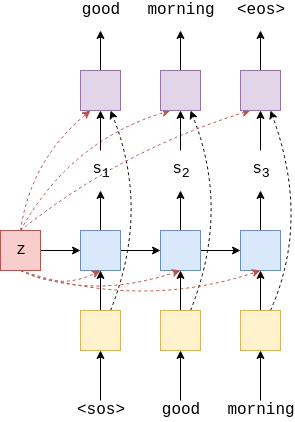

In [9]:
# from https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

        # self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding")

    def forward(self, input, hidden, context):
        
        #input = [batch_size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        embedded = self.dropout(input)
        
        #embedded = [1, batch size, emb dim]
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
      
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction.unsqueeze(0), hidden

In [10]:
class Net(nn.Module):
  """
  신경망 파일
  hidden_size : kor2vec의 embedding size 로 맞춰야 합니다.
  """
  def __init__(self, seq_len = 15, embedding_size = 64, hidden_size = 64):
    super(Net, self).__init__()
    self.seq_len = seq_len
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.resnet = models.resnet18(pretrained=True)
    self.decoder = Decoder(64, self.embedding_size, self.hidden_size, 0.5)
    self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding")

    # resNet의 모든 파라미터를 잠그고 마지막 레이어만 얼리지 않고 사용합니다.
    for param in self.resnet.parameters():
       param.requires_grad = False
    self.resnet.fc = nn.Linear(512, 64) # 마지막 레이어만 다시 사용합니다.

    # kor2vec의 모든 파라미터를 얼립니다.
    for param in self.kor2vec.parameters():
       param.requires_grad = False

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(self.seq_len, batch_size, self.embedding_size).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    output = self.kor2vec.embedding('<sos>').unsqueeze(0).repeat(1, batch_size, 1).to(device)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장합니다.
    for t in range(0, self.seq_len):
        output, hidden = self.decoder(output, hidden, x ) 
        outputs[t] = output
        

    return outputs.reshape(batch_size, self.seq_len, self.embedding_size) # shape: (15, batch_size, 1000)


  def give_embedding(self, x):  # 원도 추가 부분
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)
    
    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(self.seq_len, batch_size, self.embedding_size).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    output = self.kor2vec.embedding('<sos>').unsqueeze(0).repeat(1, batch_size, 1).to(device)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장합니다.
    output, hidden = self.decoder(output, hidden, x ) 
        
    return hidden
  
  def give_resnet_embedding(self, x):  # 원도 추가 부분
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    return hidden

  # model.train() 을 위해 메소드 오버라이딩
  def train(self, mode=True):  
    self.training = mode
    for module in self.children():
      if module != self.kor2vec:
        module.train(mode)
    return self

  # model.eval() 을 위한 설정
  def eval(self, mode=False): 
    # self.training = mode
    for module in self.children():
      if module != self.kor2vec:
        module.train(mode)
    return self

# 실제 코드 불러와서 사용

커피를 정말 좋아하는데 이 인근에서 가장 맛있는 커피샵. 인생라떼 마셨음.


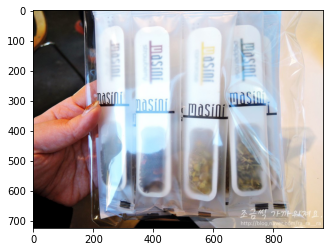

In [38]:
# 이미지 표시 : transform을 None으로 놓고 사용
img_data = CaptionDataset('/content/data', review, transform=None)
img, rev = img_data[6666]

print(rev)
plt.imshow(img)
plt.show()

In [11]:

transform = transforms.Compose(
    [transforms.ToTensor(), # 텐서로 변형
     transforms.Resize(224), # 사이즈 조절
     transforms.CenterCrop(224), # 가로와 세로 중 안 맞는 곳 자르기
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
train_data = CaptionDataset('/content/data', review, transform=transform)

img, rev = train_data[0]

print(f"img shape : {img.shape}") # ([1, 3, 224, 224]) - [배치, 채널, 가로, 세로]
print(f"rev : {rev.shape}") # ([15, 1000]) - [seq_len, hidden_size]

img shape : torch.Size([3, 224, 224])
rev : torch.Size([15, 64])


In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

In [32]:
model = Net()
criterion = nn.PoissonNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
model.to(device)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [35]:
# 신경망 학습
for epoch in range(5): # 5에포크
  running_loss = 0.0
  model.train()
  for i, data in enumerate(train_dataloader):
    img, label = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = model(img)


    loss = criterion(output, label.to(device))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    if i>= len(train_dataloader) - 1: break # 왜인지 모르겠으나 묵시적으로 enumerate가 종료되지 않아서 명시적으로 추가
    
    if (i % 10) == 0: # 매 10번 미니배치마다 출력하기
            print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / (i + 1)))
            running_loss =0.0

[1,     1] loss: 1.058
[1,    11] loss: 0.386
[1,    21] loss: 0.097
[1,    31] loss: -0.041
[1,    41] loss: -0.020
[1,    51] loss: -0.022
[1,    61] loss: -0.024
[2,     1] loss: -0.210
[2,    11] loss: -0.185
[2,    21] loss: -0.111
[2,    31] loss: -0.078
[2,    41] loss: -0.069
[2,    51] loss: -0.056
[2,    61] loss: -0.052
[3,     1] loss: -0.246
[3,    11] loss: -0.299
[3,    21] loss: -0.151
[3,    31] loss: -0.077
[3,    41] loss: -0.069
[3,    51] loss: -0.069
[3,    61] loss: -0.034
[4,     1] loss: -0.049
[4,    11] loss: -0.087
[4,    21] loss: -0.075
[4,    31] loss: -0.061
[4,    41] loss: -0.063
[4,    51] loss: -0.055
[4,    61] loss: -0.053
[5,     1] loss: -0.381
[5,    11] loss: -0.396
[5,    21] loss: -0.227
[5,    31] loss: -0.178
[5,    41] loss: -0.135
[5,    51] loss: -0.113
[5,    61] loss: -0.096


# tsne 코드

In [ ]:
!pip install lapjv==1.3.12 -q

In [ ]:
import numpy as np
import os, argparse
import matplotlib as mlp
import matplotlib.pyplot as plt
from PIL import Image
from lapjv import lapjv
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist


out_res = 64
out_name = 'tsne_grid.jpg'
out_dim = 40
to_plot = np.square(out_dim)
perplexity = 50
tsne_iter = 5000
in_dir = '/content/data'
out_dir = './'

img_table = review


def get_activations(model, img_collection):
    activations = []
    for idx in range(len(img_collection)):
        if idx == to_plot:
            break;

        if idx % 1000 == 0:
          print("image ~{} processed.".format(idx+1))

        img = review['imgname_123'][idx]
        img = os.path.join(in_dir, img)

        open_img = Image.open(img).convert('RGB')
        img = transform(open_img)

        pred = model(img.unsqueeze(0).to(device)) # (15, hidden)
        color_img = np.array((open_img.resize((10,10))))

        act = np.concatenate((pred.flatten().cpu().detach().numpy(), color_img.flatten()))
        activations.append(act)
    return activations

def generate_tsne(activations):
    tsne = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=tsne_iter)
    X_2d = tsne.fit_transform(np.array(activations)[0:to_plot,:])
    X_2d -= X_2d.min(axis=0)
    X_2d /= X_2d.max(axis=0)
    return X_2d

def save_tsne_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim*out_res, out_dim*out_res, 3), dtype=np.uint8)

    for pos, img in zip(grid_jv, img_collection['imgname_123'][0:to_plot]):
        img = os.path.join(in_dir, img)
        open_img = Image.open(img).convert('RGB')
        open_img = open_img.resize((out_res,out_res))
        h_range = int(np.floor(pos[0]* (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1]* (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res] = np.array(open_img)
   

    im = Image.fromarray(out)
    im.save(out_dir + out_name, quality=100)

print("hello")
sampled_img = img_table.sample(n=(out_dim*out_dim)).reset_index(drop=True)

activations = get_activations(model, sampled_img)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)
print("Generating image grid.")
save_tsne_grid(sampled_img, X_2d, out_res, out_dim)

hello
image ~1 processed.
image ~1001 processed.
Generating 2D representation.
Generating image grid.


# 추천 10개 표시

In [36]:
# 가장 유사한, 가장 유사하지 않은 것 비교 코드


i_list = []
resnet_embed_list = []
embed_list = []

# 모든 이미지에 대한 임베딩 계산
for i, data in enumerate(train_data):
    model.eval()
    
    img, label = data[0].to(device), data[1].to(device)
    img = img.unsqueeze(0)
    resnet_embed = model.give_resnet_embedding(img)[0].cpu().detach().numpy()[0][0]
    embed = model.give_embedding(img)[0].cpu().detach().numpy()[0][0]


    i_list.append(i)
    embed_list.append(embed)
    resnet_embed_list.append(resnet_embed)

    if i>= len(train_data) - 1: break

    if i%100 == 0:
      print(f"image done : {i}")

image done : 0
image done : 100
image done : 200
image done : 300
image done : 400
image done : 500
image done : 600
image done : 700
image done : 800
image done : 900
image done : 1000
image done : 1100
image done : 1200
image done : 1300
image done : 1400
image done : 1500
image done : 1600
image done : 1700
image done : 1800
image done : 1900
image done : 2000
image done : 2100
image done : 2200
image done : 2300
image done : 2400
image done : 2500
image done : 2600
image done : 2700
image done : 2800
image done : 2900
image done : 3000
image done : 3100
image done : 3200
image done : 3300
image done : 3400
image done : 3500
image done : 3600
image done : 3700
image done : 3800
image done : 3900
image done : 4000
image done : 4100
image done : 4200
image done : 4300
image done : 4400
image done : 4500
image done : 4600
image done : 4700
image done : 4800
image done : 4900
image done : 5000
image done : 5100
image done : 5200
image done : 5300
image done : 5400
image done : 5500
imag

target img : 200
8231, 카페에 있는 강아지가 귀엽습니다. 레몬티는 좀 싱겁다는 반응인데 제 입에는 맞았습니다.


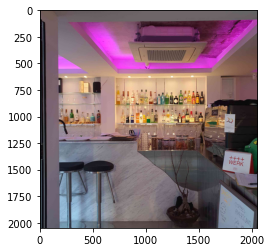

가장 가까운 이미지
0, 카페에 있는 강아지가 귀엽습니다. 레몬티는 좀 싱겁다는 반응인데 제 입에는 맞았습니다., distance : 0.0


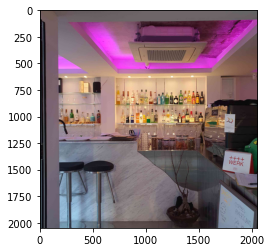

1, 고즈넉한 분위기의 성북동 한옥 카페. 맛은 있지만 가격대나 양은 보통인 편이다. 인테리어 소품이나 조명이 앤틱하다., distance : 3.7550926208496094e-06


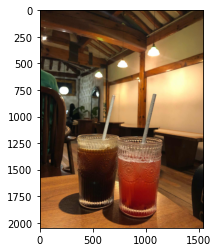

2, 마카롱 너무 맛있어요. 달곰라떼 진짜 귀엽고 사진 찍기 좋아요., distance : 1.0073184967041016e-05


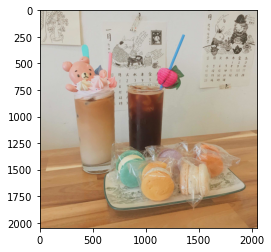

3, 사실 딸기통카타르트를 먹고 싶어서 간 곳. 근데 주문이 안 된다고 했다.
<U+2800>
마담 프로마주는 온전히 치즈로 이루어진 케이크에 유자와 파인애플 콩피로 상큼함을 더한 디저트다. 맨 밑에는 베이크드 바닐라 치즈케이크가, 중간에는 프로마주 블랑 무스가, 맨 위에는 마스카포네 크림이 올라갔다. 마스카포네 크림 위에는 상큼한 유자와 달달한 파인애플이 올라간다. 유자의 자기 주장이 강해 파인애플은 다소 묻히는 편. 전체적으로 부드럽고 가볍지만 진한 여운을 준다.
<U+2800>
바닐라 타르트는 굉장히 진하고 부드러운 바닐라 맛을 선사한다. 단단한 타르트지를 힘겹게 가르고 나면 고소한 아몬드 바닐라 크림과 진한 바닐라 가나슈의 풍미를 느낄 수 있다. 겉면은 바닐라 글라사주로 마무리해 반짝거린다. 바닐라 무스와 바닐라 가나슈, 그리고 아몬드 바닐라 크림의 조화가 상당하다. 그냥 되게 진하고 맛있는 바닐라 아이스크림을 먹는데 그 아이스크림이 차갑지 않은 느낌.
<U+2800>
지갑이 두둑할 때 한 번쯤 가볼 만한 곳. 개인적으로 내부 구조와 인테리어는 취향이 아니었다. 음료 주문이 필수라더라., distance : 2.4318695068359375e-05


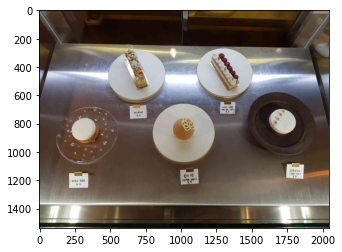

4, 분위기도 너무 좋고 맛도 좋은 브런치 맛집이에요^^ 세트로 시키면 할인도 되서 좋습니다., distance : 3.6716461181640625e-05


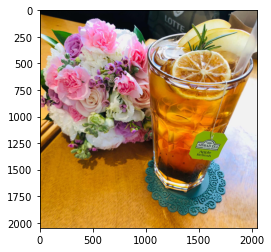

5, 신길역이랑 가까운편이구요 커피가진하고 맛이있어서 자주갑니다, distance : 6.508827209472656e-05


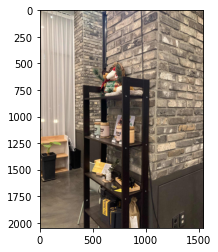

6, 친절하지도않고 특별한 맛이 있지않음 당일 기다려서 사먹을정도는 아니다, distance : 8.45193862915039e-05


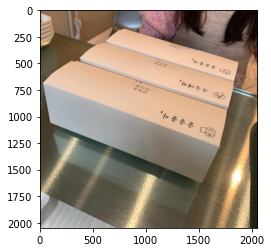

7, 진하고 크리미한 커피 메뉴와 짭짤한 스콘을 파는 곳. 어디를 찍어도 인스타에 올리기 좋을 분위기., distance : 9.08970832824707e-05


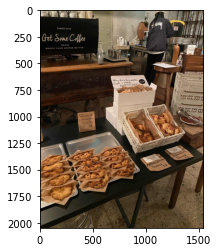

8, 소담길에서 젊은분들과 커피애호가 분들이 좋아할 카페입니다. 커피를 직접 만드는 곳으로 기계로 홀에서 직접 보여주십니다. 점심시간에는 직장인들로 엄청 혼잡합니다. 주차는 불가입니다. 형이 은은하면서 고급스럽습니다., distance : 0.00011295080184936523


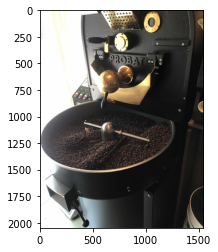

9, 작은 동네 카페입니다.
디저트 주메뉴인 핫샌드가 특이하고 맛있습니다!, distance : 0.00012624263763427734


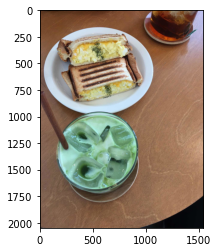

가장 먼 이미지
0, 오스트리아 동네 단골 빵집에 온 느낌.
알려지지 않았으면 싶은 청담동 숨은 보석이다.

빵 자체의 식감과 풍미가 기가막히다. 맛있다는 크롸상집 가보면 미국식 대량납품 스타일러 기름 좔좔 큰 덩치에 강렬한 버터향이 미각을 마비시켜 다른 맛을 못느낄 정도인데.. 이곳의 크로아상은 겸손하지만 강력하다. 좋은 재료를 써 신선하게 구운티가 제대로 난다. 담백하고 고소하면서도 촉촉하지만 눅눅하지 않고 지나치게 부풀어 바스라지지 않아 식감이 좋다. 한입한입이 아쉬울 지경.

샌드위치 재료와의 조화는 말할 것도 없고, 커피도 롱블랙보다 더 작은 양의 진짜 유럽 커피다ㅜㅜ 낭만적인 동유럽 도시들이 그리운 요즘..창밖은 청담동 주택가 였지만 마음만은 정말 오스트리아에 다녀온 기분이었다.

굳이 단점을 찾자면, 불친절하다ㅎ, distance : 0.5061401128768921


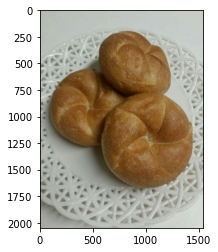

1, 딱 인스타 감성카페. 소품많음.
이 집만의 라떼가 있었는데 이름 기억안나지만 고소하고 맛있음 딸기라떼도, distance : 0.5175164341926575


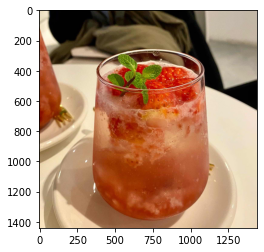

2, 요즘 제일 자주 가는 가게인듯
어떤 맛을 먹어도 어? 하게 되는 포인트가 있고 예상했던 맛보다 맛있음
개인적으로는 말차크림과 말차초콜릿 조합의 더블말차가 가장 맛있었음
딸기우유맛도 딸기아이스크림맛이라 맛있었고 봄시즌에만 판매했던 벚꽃마카롱은 바닐라크림과 백앙금과 벚꽃퓨레의 조화가 아름답게 맛있었다
흑임자라떼랑 민트초코칩도 맛있었음
자몽이랑 카시스는 그닥 취향 x
마카롱은 2천원대로 저렴한 편이고
시즌별로 나오는 마카롱이 있고 주간별로 나오는 케이크가 있는데 먹어봤던 것들 대체적으로 다 만족스러웠음, distance : 0.525579035282135


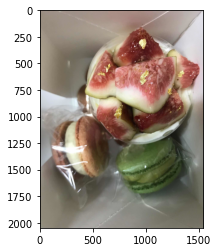

3, 아파트 지하상가에 있어서 외졌는데도 사람들 많음. 전반적으로 다 맛있음, distance : 0.5279428362846375


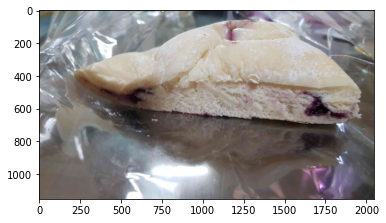

4, - 직접 커피를 사다가, 로스팅하는 카페. 매주 화요일마다 로스팅을 하고, 그때그때 원산지가 다른 다양한 원두들을 다양한 배합으로 판매함.

- 가장 마음에 드는 점은 매번 다른 블렌딩과 맛을 볼 수 있다는 점. 물론 고정 메뉴(메뉴판)이 있습니다. 개인적으로 산도는 낮고, 풍미가 높은 커피 선호하는데 딱 취향대로 마실 수 있어서 좋아요.

- 원두도 구매가능한데, 추천 블렌딩이나 희망 블렌딩해서 구매도 가능.

- 사람이 많아지면 느려디는 와이파이 환경, 평일 오후 8시까지 영업하고, 일요일이나 공휴일에는 영업 안하는 점이 아쉽습니다.

- 특히 화장실은 남녀공용인데 옛날 건물이라 조-큼 후집니다<U+0001F602>, distance : 0.5320186614990234


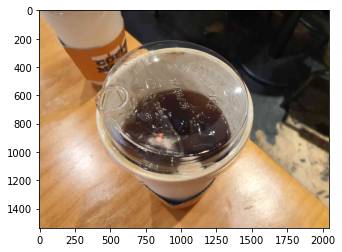

5, 가게가 정말 예뻐요. 음료도 먹을만하구요. 그런데 음악을 유튜브로 트시는지 중간에 광고가 나오더라구요..트는 것도 히트곡 탑 100 트시는 것 같고.. 하지만 혼자 작업하기 좋고 사진찍으면 예쁘게 잘 나올 것 같아요., distance : 0.5616205334663391


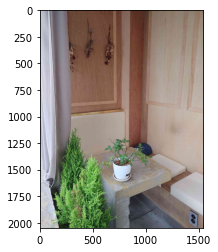

6, 주차는 불가능 합니다. 커피랑 디저트 맛있어요. 재방문 의사 있어요., distance : 0.5731379389762878


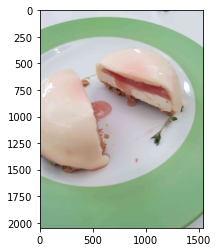

7, 아파트가 들어선 산동네에 쌩뚱 맞게 위치한 카페 아기자기 잘 꾸며놓은 인테리어와. 편한 의자. 여로모로 괜찮았다. 평일에 홀로와 앉아 있기 좋은곳., distance : 0.6093764901161194


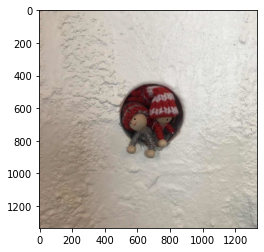

8, 내 생애최악의 브리또가되시것다...서울역이라그런가 스콘을 먹엇어야하나..돈아깝다, distance : 0.6259983777999878


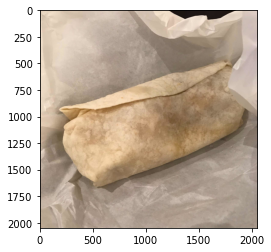

9, 아파트 지하상가에 있어서 외졌는데도 사람들 많음. 전반적으로 다 맛있음, distance : 0.6616731882095337


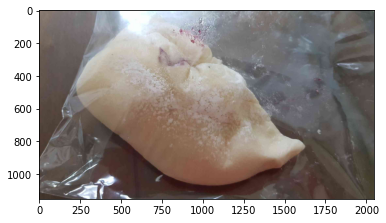

In [39]:

# text embedding 을 한 것을 통해 target image와 가장 가까운 10개, 가장 먼 10개 보여주기
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt

tmp = np.array(embed_list).reshape(-1,1)
dist_mtx = euclidean_distances(tmp,tmp)

target_idx = 200

# 가장 가까운 것의 인덱스를 제공해준다
# ex target_idx가 200이라면, 첫 인덱스는 200
close_list = dist_mtx[target_idx].argsort()[0:10]
far_list = dist_mtx[target_idx].argsort()[-11:-1]

print(f"target img : {target_idx}")
img, rev = img_data[target_idx]
print(f"{i}, {rev}")
plt.imshow(img)
plt.show()


print("가장 가까운 이미지")
print("======================")
# target을 포함해 target과 가장 가까운 것 10개
for i, idx in enumerate(close_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()

print("가장 먼 이미지")
print("======================")
# target과 가장 먼것 10개
for i, idx in enumerate(far_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()



target img : 200
9, 카페에 있는 강아지가 귀엽습니다. 레몬티는 좀 싱겁다는 반응인데 제 입에는 맞았습니다.


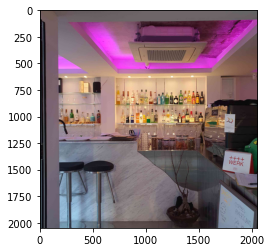

가장 가까운 이미지
0, 카페에 있는 강아지가 귀엽습니다. 레몬티는 좀 싱겁다는 반응인데 제 입에는 맞았습니다., distance : 0.0


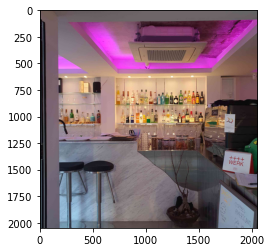

1, 생일카페 때문에 갔던 곳인데 원래도 케이크 예뻐서 유명한 곳이라고 한다. 실제로도 케이크가 진짜 너무너무 예뻤고 맛있기까지 했다. 달고나 라떼도 난생 처음 도전해봤는데 달달한 살짝 탄맛나는 커피인거같아거 너무 맛있었다., distance : 1.049041748046875e-05


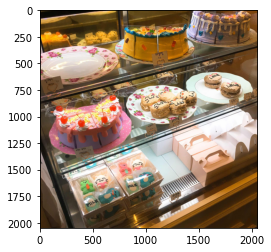

2, 투숙객 할인 10% 받아서 좀 더 저렴하게 이용함. 좌석도 꽤 많고 음식이 신선해서 맛있었음. 특히 육회랑 디저트 종류가 맛있었음, distance : 5.3048133850097656e-05


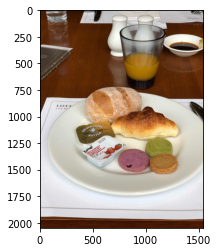

3, 동네 큰 카페. 가격이 정말 맘에 든다. 커플이나 젊은 사람들보다는 모임하는 어르신들ㅇ 더 많음, distance : 6.866455078125e-05


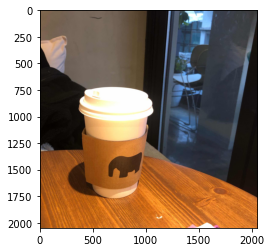

4, 조용하고 넓직해서 데이트하기 좋고 차나 술을 하기도 괜찮은 분위기였고 가격 괜찮고 주변카페 대비 영업시간이 길어서 좋았음, distance : 0.00013005733489990234


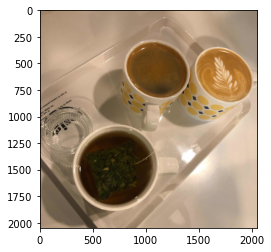

5, 너무너무 예쁜 카페예요~
의자가 각각 다르구
아기자기하게 꾸며있어요!
외관이 예쁘구요!, distance : 0.00016033649444580078


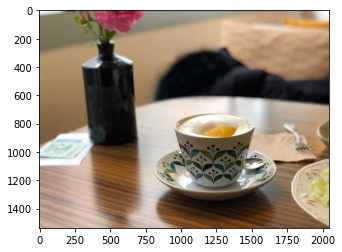

6, 병원 앞에 카페를 찾다가 방문한 곳. 저렴한 가격, 친절한 응대, 기호에 맞는 커피맛이 만족스러웠다., distance : 0.00020611286163330078


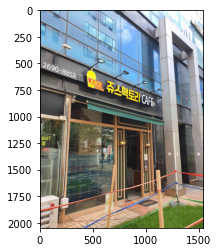

7, 밀키 우롱을 주문했고 차는 맑은데 뒤에는 우유의 맛이 느껴져서 신기했습니다. 같이 주는 호두 스낵도 맛있습니다., distance : 0.00023663043975830078


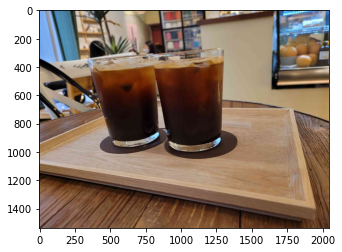

8, 드립 커피를 맛있게 해줘서 양재천 산책 전후에 들리고는 합니다. 케이크도 보기보다 괜찮네요, distance : 0.00024318695068359375


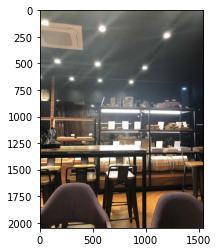

9, 지인소개로 가게 되었는데 커피도 맛있고 뷰도 좋았다.
테이블 간격도 넓어서 좋았음.
주말에 가면 웨이팅있을듯하다., distance : 0.00030219554901123047


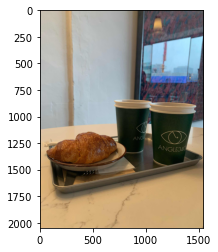

가장 먼 이미지
0, 힙지로에서 핫한 카페,, 간판이 없어서 겨우 찾아서 들어갔는데 레트로하면서 유니크한 분위기에 반했네요 음료는 맛은 보통인듯~ 아이스 초콜릿 차이 밀크티 괜춘했어용, distance : 1.625841736793518


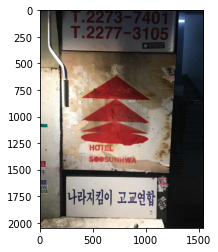

1, 테이크아웃시 -1000원이 메리트 있어요. 커피향도 정말 좋고 맛도 풍부하고 진해요., distance : 1.6875743865966797


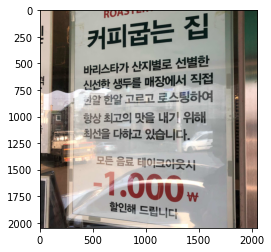

2, 이런곳이 카페가 있다고..? 하는곳에 있는 을지로 감성 뿜뿜한 쌍문역 카페 오픈더도어
사장님도 친절하시고 달달하고 귀여운 당근케이크 맛집 !, distance : 1.6961873769760132


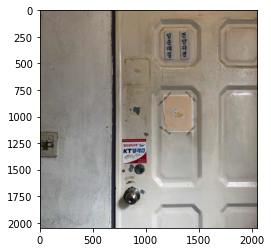

3, 홍대점에서 처음 가봤는데 맛이 괜찮아서 이 지점에도 방문해봤어요. 동윤영이 메뉴로 있는 게 너무 반가워서 주문해봤는데 맛이 괜찮네요. 현대백화점에서 파르나스몰 잇는 통로에 바로 있습니다., distance : 1.704819917678833


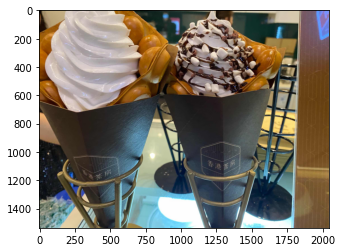

4, 과일이 올라가는 토스트를 주문했는데 커팅을 잘못 했다며 마시멜로토스트를 같이 주었다.
밀크티도 깔끔하고 토스트는 맛 없을 수가 없는 조합..
좁긴한데 가죽공예품을 한켠에서 같이 판다.
갔을때 사장님과 친구분이 떡볶이를 시켜먹어서인지 냄새가 좀 났던거 빼고는 나쁘지 않다.
이런 인스타감성의 카페가 땡길때 한번쯤 가볼 만 한 것 같다., distance : 1.7054038047790527


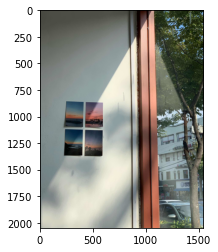

5, 매장도 이쁘고 빵들도 다 너무 맛있어요!
친절하게 맞아주시고 포장도 정성스럽게 해주셨어요.
먹은 것 중에 당근 케잌이 제일 맛있었고 상큼달콤한 딸기와 크림의 타르트도 좋았어요!, distance : 1.707017183303833


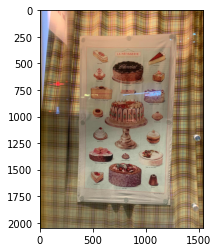

6, 위치는 송리단길에서 좀 떨어져있는 큰길가 건물이라 사람이 있을까 싶었는데 입구에서 부터 느껴지는 핫플레이스 사운드.. 개인적으로 사람많은 카페는 싫어하는지라 별 기대 안하고 들어갔습니다. 커피는 너무 비쌌어요. 자리값인듯.. 솔티드는 제 취향이 아니었지만 아이스코코넛라떼는 맛있었어요. 테라스쪽에는 이미 만석이라 안쪽 소파에 앉아있다가 윗층 포토존이라는 곳에 올라가봤는데 왜 여기가 사람들한테 유명한 카페인지 알겠더라구요. 롯데타워가 바로 보이는 야경이 사진찍기에 너무 이뻤습니다. 연인들이나 가족들 친구들이 한번쯤 사진찍으러 오기에 괜찮은거 같아요. 공휴일이나 주말 저녁은 피해서 가는걸 추천합니다!, distance : 1.7295504808425903


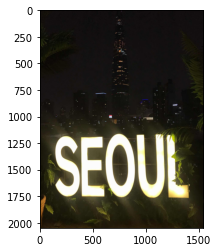

7, 비엔나 커피 크림이 정말 맛있어요! 내부도 생각보다 넓어요!, distance : 1.7396628856658936


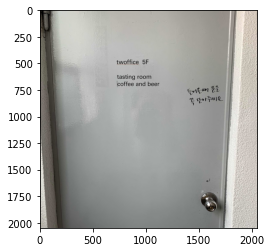

8, 케잌이 달면서도 물리지 않고 계속 들어가네요 ㅠㅜ 음료도 라지컵 가득 담아줘서 완전 만족!, distance : 1.8259650468826294


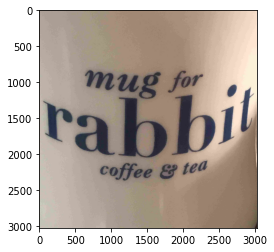

9, 테라스가 어마어마한 해방촌 카페
숨은 보석같은 카페
나만 알고 싶은 카페, distance : 1.8855054378509521


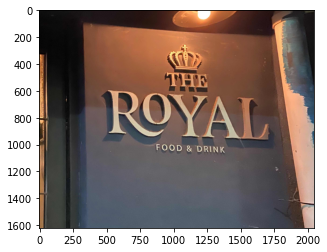

In [ ]:
# resnet embedding 만을 썼을때 target image와 가장 가까운 10개, 가장 먼 10개 보여주기
#
tmp = np.array(resnet_embed_list).reshape(-1,1)
dist_mtx = euclidean_distances(tmp,tmp)

target_idx = 200

# 가장 가까운 것의 인덱스를 제공해준다
# ex target_idx가 200이라면, 첫 인덱스는 200
close_list = dist_mtx[target_idx].argsort()[0:10]
far_list = dist_mtx[target_idx].argsort()[8226:8236]

print(f"target img : {target_idx}")
img, rev = img_data[target_idx]
print(f"{i}, {rev}")
plt.imshow(img)
plt.show()
print("======================")

print("가장 가까운 이미지")
print("======================")
# target을 포함해 target과 가장 가까운 것 10개
for i, idx in enumerate(close_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()

print("가장 먼 이미지")
print("======================")
# target과 가장 먼것 10개
for i, idx in enumerate(far_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()



In [ ]:
close_list

array([ 200, 5867, 3828, 6924,  287, 7804, 5155, 5607, 3577, 4021])

In [40]:
torch.save(model.state_dict(), "/content/drive/MyDrive/trained_model/recsys_cafe")